_Autor:_    __Jesús Casado__ <br> _Revisión:_ __8/11/2019__ <br>

__Introducción__<br>


__Cosas a mejorar__ <br>
* La temperatura a usar puede ser la mínima o la media. Analizar.
* Incluir insolación mediante el índice de radiación.

***

__Índice__ <br>

In [1]:
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [10]:
import numpy as np
import pandas as pd

In [2]:
import numpy.ma as ma

In [261]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()

In [4]:
from netCDF4 import Dataset
from datetime import date, datetime, timedelta

## Datos

In [6]:
rutaData = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/data/'
os.chdir(rutaData)

In [39]:
# Cargar netCDF con los datos climáticos
nc = Dataset('clima_1265.nc', 'r', format='NETCDF4')

# extraer variables
X = nc['X'][:].data
Y = nc['Y'][:].data
dates = nc['time'][:].data
dates = np.array([date(1979, 1, 1) + timedelta(days=int(d)) for d in dates])
pcp = nc['pcp'][::]
tmp = nc['tmp'][::]

nc.close()

#### Recortar periodo de estudio

In [227]:
# fechas de inicio y fin
start = datetime(2014, 10, 1).date()
end = datetime(2015, 10, 1).date()

In [228]:
# posición dentro de la serie temporal
st = np.where(dates == start)[0][0]
en = np.where(dates == end)[0][0]
st, en

(13057, 13422)

In [229]:
# recortar
dates_ = dates[st:en]
pcp_ = pcp[st:en,:,:]
tmp_ = tmp[st:en,:,:]

## Método de grado día

In [275]:
def DDM(pcp, tmp, Ts=0., Tb=0., DDF1=2., DDF2=4., verbose=True):
    """
    """
    
    # array 3D en blanco
    arr3D = ma.masked_array(np.zeros(pcp_.shape), pcp_.mask)
    # array 2D en blanco
    arr2D = ma.masked_array(np.zeros(pcp_[0,:,:].shape), pcp_[0,:,:].mask)
    
    # arrays donde guardar los resultados
    swe = arr3D.copy()  # equivalente agua-nieve (snow-water equivalent)
    sm = arr3D.copy()   # fusión de la nieve (snowmelt)
    
    for i, date in enumerate(dates_):
        if verbose:
            print('Paso {0:<3} de {1:<3}:\t{2}'.format(i+1, len(dates_), date), end='\r')

        # extraer mapas con los datos
        pcp_i = pcp_[i,:,:]   # precipitación
        tmp_i = tmp_[i,:,:]   # temperatura
        swe_0 = swe[i-1,:,:]  # equivalente agua-nieve inicial

        # precipitación en forma de nieve
        snowfall = arr2D.copy()
        maskT = tmp_i < Ts
        snowfall[maskT] = pcp_i[maskT]

        # fusión de la nieve potencial (snowmelt)
        snowmelt = arr2D.copy()
        # en celdas sin lluvia
        dry = pcp_i <= 0
        snowmelt[dry] = DDF1 * (tmp_i[dry] - Tb)
        # en celdas con lluvia
        rain = pcp_i > 0
        snowmelt[rain] = DDF2 * (tmp_i[rain] - Tb)
        # convertir en 0 valores negativos (cuando la temperatura es inferior a Tb)
        snowmelt[snowmelt < 0] = 0

        # equivalente de agua-nieve disponible
        swe_i = swe_0 + snowfall

        # fusión de la nieve real (snowmelt_)
        snowmelt_ = arr2D.copy()
        mask1 = snowmelt >= swe_i
        snowmelt_[mask1] = swe_i[mask1]
        mask2 = snowmelt < swe_i
        snowmelt_[mask2] = snowmelt[mask2]
        sm[i,:,:] = snowmelt_.copy()

        # equivalente agua-nieve final
        swe_i -= snowmelt_
        swe[i,:,:] = swe_i.copy()
        
    return swe, sm

In [276]:
swe, sm = DDM(pcp, tmp, Ts=0., Tb=0., DDF1=2., DDF2=4., verbose=True)

In [266]:
Ts, Tb, DDF1, DDF2 = 0., 0., 2., 4.

In [267]:
# array 3D en blanco
arr3D = ma.masked_array(np.zeros(pcp_.shape), pcp_.mask)

In [268]:
# array 2D en blanco
arr2D = ma.masked_array(np.zeros(pcp_[0,:,:].shape), pcp_[0,:,:].mask)

In [269]:
# equivalente agua-nieve (snow-water equivalent)
swe = arr3D.copy()
# fusión de la nieve (snowmelt)
sm = arr3D.copy()

In [270]:
i = 113
date = dates_[i]

In [271]:
for i, date in enumerate(dates_):
    print('Paso {0:<3} de {1:<3}:\t{2}'.format(i+1, len(dates_), date), end='\r')
    
    # extraer mapas con los datos
    pcp_i = pcp_[i,:,:]   # precipitación
    tmp_i = tmp_[i,:,:]   # temperatura
    swe_0 = swe[i-1,:,:]  # equivalente agua-nieve inicial

    # precipitación en forma de nieve
    snowfall = arr2D.copy()
    maskT = tmp_i < Ts
    snowfall[maskT] = pcp_i[maskT]

    # fusión de la nieve potencial (snowmelt)
    snowmelt = arr2D.copy()
    # en celdas sin lluvia
    dry = pcp_i <= 0
    snowmelt[dry] = DDF1 * (tmp_i[dry] - Tb)
    # en celdas con lluvia
    rain = pcp_i > 0
    snowmelt[rain] = DDF2 * (tmp_i[rain] - Tb)
    # convertir en 0 valores negativos (cuando la temperatura es inferior a Tb)
    snowmelt[snowmelt < 0] = 0

    # equivalente de agua-nieve disponible
    swe_i = swe_0 + snowfall

    # fusión de la nieve real (snowmelt_)
    snowmelt_ = arr2D.copy()
    mask1 = snowmelt >= swe_i
    snowmelt_[mask1] = swe_i[mask1]
    mask2 = snowmelt < swe_i
    snowmelt_[mask2] = snowmelt[mask2]
    sm[i,:,:] = snowmelt_.copy()

    # equivalente agua-nieve final
    swe_i -= snowmelt_
    swe[i,:,:] = swe_i.copy()

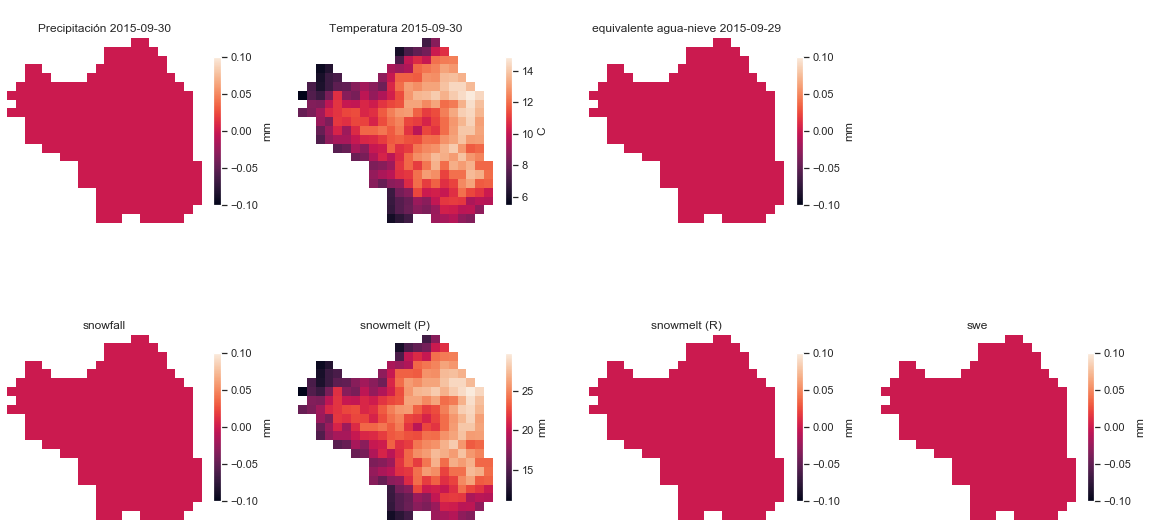

In [272]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
extent = [X.min(), X.max(), Y.min(), Y.max()]

# mapa de precipitación media
im = ax[0,0].imshow(pcp_i, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,0])
cb.set_label('mm')
ax[0,0].set_title('Precipitación {0}'.format(date))
ax[0,0].axis('off');

# mapa de temperatura media
im = ax[0,1].imshow(tmp_i, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,1])
cb.set_label('C')
ax[0,1].set_title('Temperatura {0}'.format(date))
ax[0,1].axis('off');

# equivalente agua-nieve inicial
im = ax[0,2].imshow(swe_0, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,2])
cb.set_label('mm')
ax[0,2].set_title('equivalente agua-nieve {0}'.format(dates_[i-1]))
ax[0,2].axis('off');

ax[0,3].axis('off')

# precipitación en forma de nieve
im = ax[1,0].imshow(snowfall)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,0])
cb.set_label('mm')
ax[1,0].set_title('snowfall')
ax[1,0].axis('off');

# fusión potencial
im = ax[1,1].imshow(snowmelt)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,1])
cb.set_label('mm')
ax[1,1].set_title('snowmelt (P)')
ax[1,1].axis('off');

# fusión real
im = ax[1,2].imshow(snowmelt_)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,2])
cb.set_label('mm')
ax[1,2].set_title('snowmelt (R)')
ax[1,2].axis('off');

# equivalente agua-nieve
im = ax[1,3].imshow(swe_i)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,3])
cb.set_label('mm')
ax[1,3].set_title('swe')
ax[1,3].axis('off');

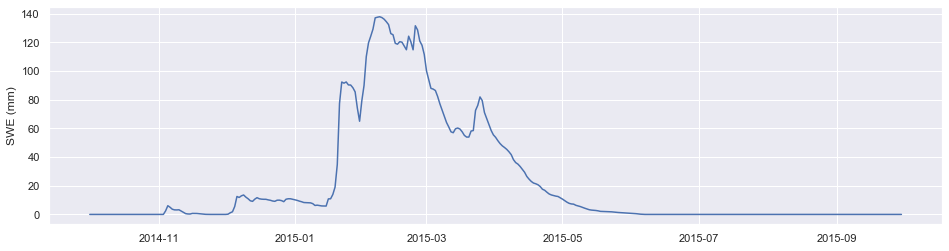

In [288]:
serie = pd.Series(swe.mean(axis=(1,2)), index=dates_)

plt.figure(figsize=(16, 4))
plt.ylabel('SWE (mm)')
plt.plot(serie);

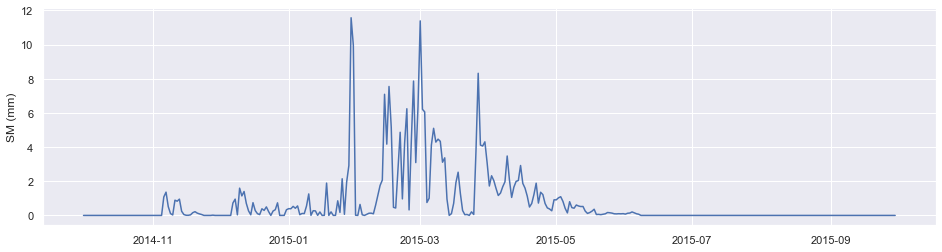

In [289]:
serie = pd.Series(sm.mean(axis=(1,2)), index=dates_)

plt.figure(figsize=(16, 4))
plt.ylabel('SM (mm)')
plt.plot(serie);